# Example `Dysmalpy` model #

**Includes the following components:**

 - Disk + Bulge
 - NFW halo
 - Constant velocity dispersion

## Setup steps ##

**Import modules**

In [1]:
from __future__ import (absolute_import, division, print_function, unicode_literals)

import numpy as np
import astropy.units as u
import astropy.io.fits as fits
import copy

from dysmalpy import galaxy, models, instrument, parameters, \
                     plotting, observation, aperture_classes


**Setup notebook**

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rcParams['figure.dpi']= 300
mpl.rc("savefig", dpi=300)

**Import functions to tie scale height relative to effective radius, 
and the halo mass to the $\boldsymbol{f_{DM}}$ value**

In [3]:
from dysmalpy.fitting_wrappers.tied_functions import tie_sigz_reff, tie_lmvirial_to_fdm, \
                                                     tied_geom_lambda

---------

## Initialize galaxy & model set

In [4]:
gal = galaxy.Galaxy(z=2., name='galaxy')
mod_set = models.ModelSet()

### Baryonic component: Combined Disk+Bulge

In [5]:
total_mass = 10.5    # M_sun
bt = 0.3             # Bulge-Total ratio
r_eff_disk = 4.0     # kpc
n_disk = 1.0
invq_disk = 5.0
r_eff_bulge = 1.0    # kpc
n_bulge = 4.0
invq_bulge = 1.0
noord_flat = True    # Switch for applying Noordermeer flattening

# Fix components
bary_fixed = {'total_mass': False,
              'r_eff_disk': False,
              'n_disk': True,
              'r_eff_bulge': True,
              'n_bulge': True,
              'bt': False}

# Set bounds
bary_bounds = {'total_mass': (10, 13),
               'r_eff_disk': (1.0, 30.0),
               'n_disk': (1, 8),
               'r_eff_bulge': (1, 5),
               'n_bulge': (1, 8),
               'bt': (0, 1)}

bary = models.DiskBulge(total_mass=total_mass, bt=bt,
                        r_eff_disk=r_eff_disk, n_disk=n_disk,
                        invq_disk=invq_disk,
                        r_eff_bulge=r_eff_bulge, n_bulge=n_bulge,
                        invq_bulge=invq_bulge,
                        noord_flat=noord_flat,
                        name='disk+bulge',
                        fixed=bary_fixed, bounds=bary_bounds)

bary.r_eff_disk.prior = parameters.BoundedGaussianPrior(center=5.0, stddev=1.0)

### Halo component

In [6]:
mvirial = -99
conc = 5.0
fdm = 0.5

halo_fixed = {'mvirial': False,
              'conc': True, 
              'fdm': False}

halo_bounds = {'mvirial': (10, 13),
               'conc': (1, 20),
               'fdm': (0, 1)}

halo = models.NFW(mvirial=mvirial, conc=conc, fdm=fdm, z=gal.z,
                  fixed=halo_fixed, bounds=halo_bounds, name='halo')
halo.mvirial.tied = tie_lmvirial_to_fdm
# The tied component must have "fixed=False", and then a specified tied function 

### Dispersion profile

In [7]:
sigma0 = 39.   # km/s
disp_fixed = {'sigma0': False}
disp_bounds = {'sigma0': (5, 300)}

disp_prof = models.DispersionConst(sigma0=sigma0, fixed=disp_fixed,
                                          bounds=disp_bounds, name='dispprof', tracer='line')

### z-height profile

In [8]:
sigmaz = 0.9   # kpc
zheight_fixed = {'sigmaz': False}

zheight_prof = models.ZHeightGauss(sigmaz=sigmaz, name='zheightgaus',
                                   fixed=zheight_fixed)
zheight_prof.sigmaz.tied = tie_sigz_reff

# The tied component must have "fixed=False", and then a specified tied function

### Geometry

Use the same settings for the 1D and 2D mocks:

In [ ]:
inc = 62.     # degrees
pa = 142.     # degrees, blue-shifted side CCW from north
xshift = 0    # pixels from center
yshift = 0    # pixels from center

geom_fixed = {'inc': False,
              'pa': True,
              'xshift': True,
              'yshift': True}

geom_bounds = {'inc': (0, 90),
               'pa': (90, 180),
               'xshift': (0, 4),
               'yshift': (-10, -4)}

geom = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift,
                       fixed=geom_fixed, bounds=geom_bounds, name='geom', 
                       obs_name='mock')

geom_1D = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift,
                          fixed=geom_fixed, bounds=geom_bounds, name='geom_1D', 
                          obs_name='mock_1D')

# Tie the inc / PA to the 2D geom:
geom_1D.inc.tied = tied_geom_lambda('geom', 'inc')
geom_1D.pa.tied = tied_geom_lambda('geom', 'pa')

### Add all model components to ModelSet

In [10]:
mod_set.add_component(bary, light=True)
mod_set.add_component(halo)
mod_set.add_component(disp_prof)
mod_set.add_component(zheight_prof)
mod_set.add_component(geom)
mod_set.add_component(geom_1D)

### Set kinematic options for calculating velocity profile

In [11]:
mod_set.kinematic_options.adiabatic_contract = False
mod_set.kinematic_options.pressure_support = True

## Set up observations

### Set up the 1D + 2D observation & instruments:

In [12]:
obs = observation.Observation(name='mock', tracer='line')
inst = instrument.Instrument()

In [13]:
beamsize = 0.55*u.arcsec                 # FWHM of beam
sig_inst = 45*u.km/u.s                   # Instrumental spectral resolution

beam = instrument.GaussianBeam(major=beamsize)
lsf = instrument.LSF(sig_inst)

In [14]:
inst.ndim = 2

inst.beam = beam
inst.lsf = lsf
inst.pixscale = 0.125*u.arcsec           # arcsec/pixel
inst.fov = [33, 33]                      # (nx, ny) pixels
inst.spec_type = 'velocity'              # 'velocity' or 'wavelength'
inst.spec_step = 10*u.km/u.s             # Spectral step
inst.spec_start = -1000*u.km/u.s         # Starting value of spectrum
inst.nspec = 201                         # Number of spectral pixels

# Set the beam kernel so it doesn't have to be calculated every step
inst.set_beam_kernel()
inst.set_lsf_kernel()

In [15]:
obs_1D = observation.Observation(name='mock_1D', tracer='line')
inst_1D = copy.deepcopy(inst)
inst_1D.ndim = 1

In [16]:
# inst_1D.ndim = 1

# inst_1D.beam = beam
# inst_1D.lsf = lsf
# inst_1D.pixscale = 0.125*u.arcsec           # arcsec/pixel
# inst_1D.fov = [33, 33]                      # (nx, ny) pixels
# inst_1D.spec_type = 'velocity'              # 'velocity' or 'wavelength'
# inst_1D.spec_step = 10*u.km/u.s             # Spectral step
# inst_1D.spec_start = -1000*u.km/u.s         # Starting value of spectrum
# inst_1D.nspec = 201                         # Number of spectral pixels

# # Set the beam kernel so it doesn't have to be calculated every step
# inst_1D.set_beam_kernel()
# inst_1D.set_lsf_kernel()

### Add the model set, observations to the Galaxy

In [17]:
gal.model = mod_set

obs.instrument = inst
gal.add_observation(obs)

In [18]:
obs_1D.instrument = inst_1D

obs_1D_options = observation.ObsOptions(oversample=3)

obs_1D.obs_options = obs_1D_options


# Define apertures:
aper_arr = np.linspace(-(inst_1D.fov[0]-1)/2., (inst_1D.fov[0]-1)/2., 
                           num=inst_1D.fov[0])*inst_1D.pixscale.value
apertures = aperture_classes.setup_aperture_types(obs=obs_1D, profile1d_type='circ_ap_cube',
            slit_width = 0.55, aper_centers=aper_arr, slit_pa=142.)

obs_1D.instrument.apertures = apertures

gal.add_observation(obs_1D)

## Create models
Creates models for all observations -- including both the 1D and 2D cases.

In [19]:
gal.create_model_data()

In [20]:
# %debug

In [22]:
gal.create_model_data(obs_list=['mock'])

In [30]:
gal.create_model_data(obs_list=['mock_1D'])

In [23]:
gal.observations

OrderedDict([('mock', <dysmalpy.observation.Observation at 0x130d13610>),
             ('mock_1D', <dysmalpy.observation.Observation at 0x130d271f0>)])

In [24]:
gal.observations['mock'].__dict__.keys()

dict_keys(['name', 'tracer', 'weight', '_instrument', '_data', 'model_cube', 'model_data', 'obs_options'])

In [25]:
gal.observations['mock'].model_data

In [31]:
gal.observations['mock_1D'].model_data

In [27]:
print(gal.observations['mock'].model_data)

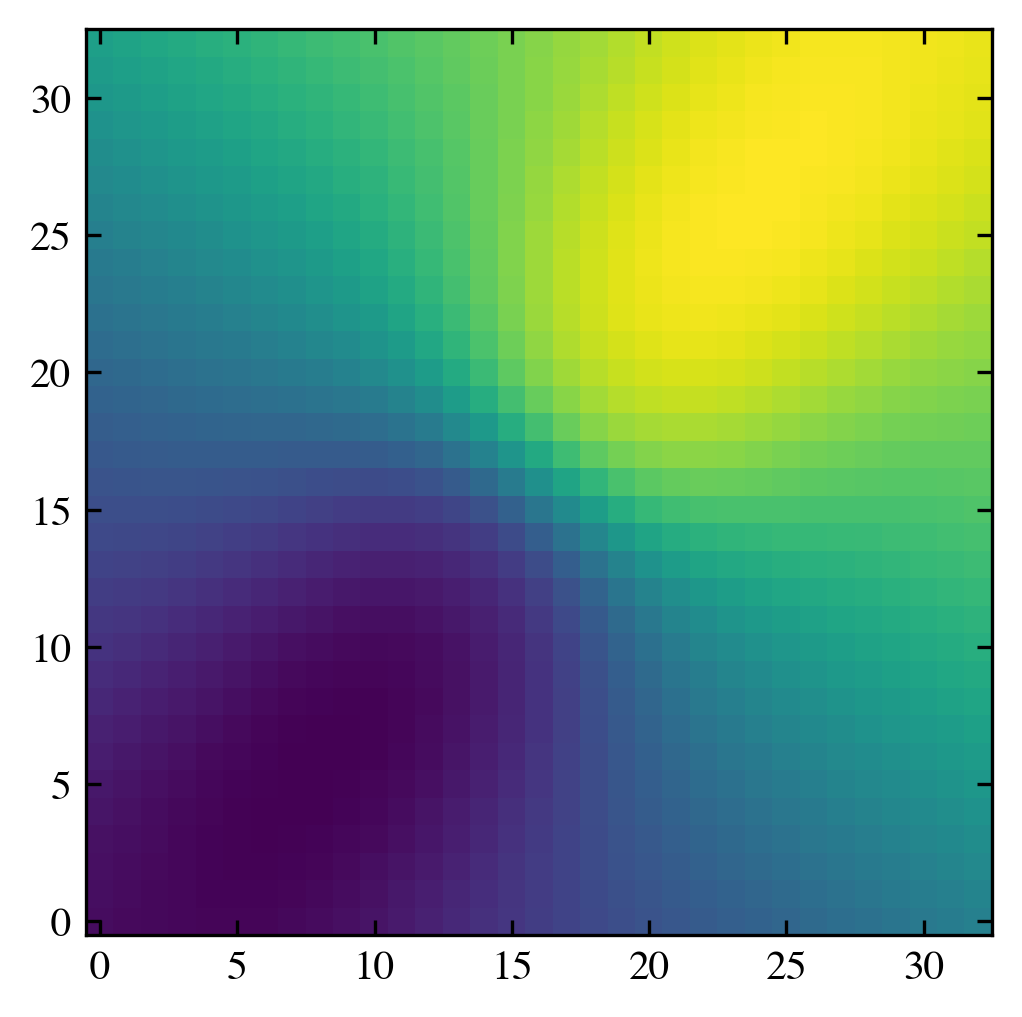

In [28]:
plt.imshow(gal.observations['mock'].model_data.data['velocity'], origin='lower')

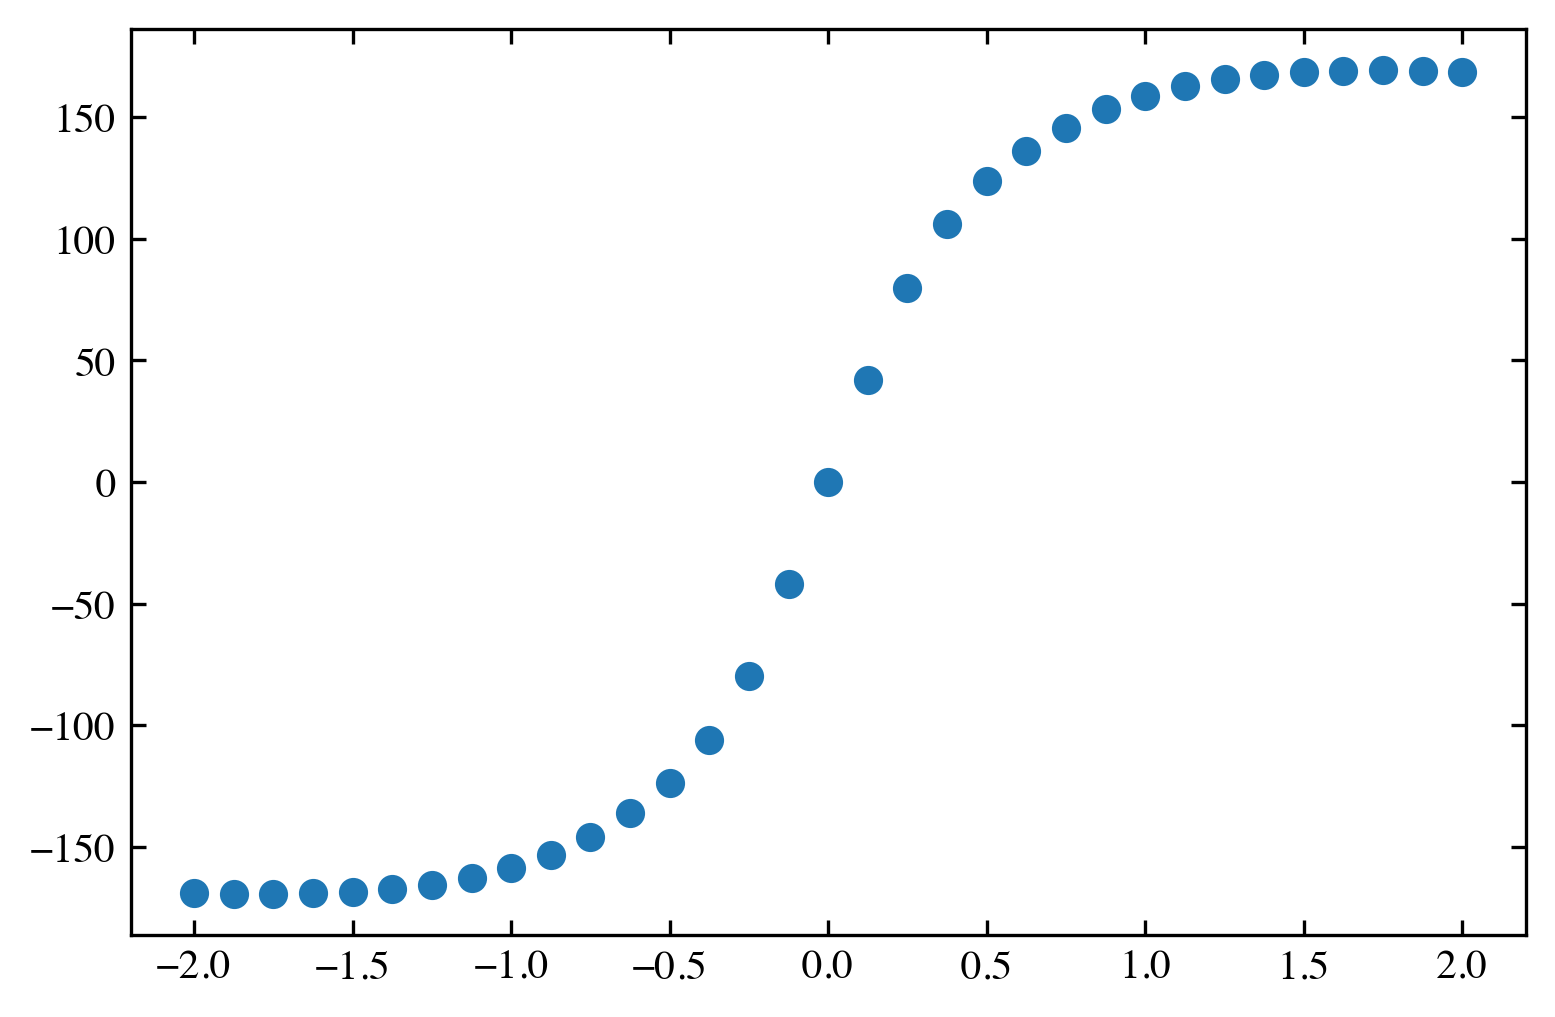

In [32]:
plt.scatter(gal.observations['mock_1D'].model_data.rarr, 
            gal.observations['mock_1D'].model_data.data['velocity'])

### 2D model

In [29]:
plotting.plot_model_2D(gal, inst_corr=True)

ValueError: Single argument to subplot must be a three-digit integer, not '121'

<Figure size 2850x1800 with 0 Axes>

### 1D model

In [ ]:
plotting.plot_model_1D(gal, inst_corr=True, best_dispersion=sigma0)